# TestGrid_EDA 


In this notebook we will explore how to access the existing testgrid data at testgrid.k8s.io, giving specific attention to [Red Hat's CI dashboards](https://testgrid.k8s.io/redhat-openshift-informing).

To start, we will rely on some of the work already established by the sippy team [here](https://github.com/openshift/sippy/blob/46ad8d209ed1f4b8d5e5e6fa8033088a593d695c/main.go#L49-L249) to access the data aggregated in testgrid and convert it into a format that can directly analyzed in a notebook.  

What is testgrid? According to the project's [readme](https://github.com/GoogleCloudPlatform/testgrid) it is a, "highly configurable, interactive dashboard for viewing your test results in a grid!" In other words, its an aggregation and visualization platform for CI data. Hopefully this aggregation encodes some of the subject matter experts knowledge, and will provide some better initial results then going straight to more complex underlying CI data.     

Also, here we will be making the assumption that the grid format for visualizing CI data, with columns representing days and rows representing tests with the value of each being either passed, failed, or not run, as a meaningful representation for further analysis and possible machine learning application.    

In [1]:
import requests
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

### List all the available dashboards

In [2]:
response = requests.get("https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar")

In [3]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[2]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-3.11-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redha

### Inspect at a specific release summary dashboard

Now that we have a progammatic way of collecting all the dashboard names, let's take a look at a specific dashboard and see what kind of info its summary holds. 

In [4]:
dashboard = "redhat-openshift-ocp-release-4.2-informing"

In [5]:
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")

In [6]:
data = response.json()

In [7]:
ocp42 = pd.DataFrame(data)
ocp42

,promote-release-openshift-machine-os-content-e2e-aws-4.1,promote-release-openshift-machine-os-content-e2e-aws-4.2,promote-release-openshift-machine-os-content-e2e-aws-4.2-s390x,release-openshift-ocp-e2e-aws-scaleup-rhel7-4.2,release-openshift-ocp-installer-console-aws-4.2,release-openshift-ocp-installer-e2e-aws-fips-4.2,release-openshift-ocp-installer-e2e-aws-fips-serial-4.2,release-openshift-ocp-installer-e2e-aws-mirrors-4.2,release-openshift-ocp-installer-e2e-aws-proxy-4.2,release-openshift-ocp-installer-e2e-aws-upi-4.2,...,release-openshift-origin-installer-e2e-aws-sdn-multitenant-4.2,release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.2-ci,release-openshift-origin-installer-e2e-aws-upgrade-4.2-stable-to-4.2-nightly,release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2,release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.2,release-openshift-origin-installer-e2e-azure-upgrade-4.2,release-openshift-origin-installer-e2e-gcp-4.2,release-openshift-origin-installer-e2e-gcp-serial-4.2,release-openshift-origin-installer-e2e-gcp-upgrade-4.2,release-openshift-origin-installer-old-rhcos-e2e-aws-4.2
alert,,,,,,no completed results,no completed results,,,,...,,,,,,,,,,
last_run_timestamp,1600197132000,1600198632000,1600200791000,1600169696000,1600197799000,0,0,1600178792000,1600182701000,1600197930000,...,1600182272000,1600197512000,1600196667000,1600203731000,1600164334000,1600178790000,1600178790000,1600187476000,1600178789000,1600171230000
last_update_timestamp,1600203661,1600203663,1600203659,1600203744,1600203740,1600203747,1600203750,1600203769,1600203781,1600203780,...,1600203851,1600203864,1600203851,1600203857,1600203855,1600203868,1600203893,1600203871,1600203889,1600203884
latest_green,,,,2e1b15841,1,no recent greens,no recent greens,1,1,1,...,1,1,1,no recent greens,1,1,1,1,1,1
overall_status,PASSING,PASSING,PASSING,FLAKY,PASSING,STALE,STALE,FLAKY,FLAKY,FLAKY,...,FLAKY,PASSING,FLAKY,FAILING,FLAKY,FLAKY,FLAKY,FLAKY,FLAKY,FLAKY
overall_status_icon,done,done,done,remove_circle_outline,done,error_outline,error_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline,...,remove_circle_outline,done,remove_circle_outline,warning,remove_circle_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline
status,10 of 10 (100.0%) recent columns passed (10 of...,10 of 10 (100.0%) recent columns passed (10 of...,10 of 10 (100.0%) recent columns passed (10 of...,3 of 10 (30.0%) recent columns passed (5547 of...,10 of 10 (100.0%) recent columns passed (3790 ...,no completed results,no completed results,7 of 10 (70.0%) recent columns passed (8231 of...,6 of 10 (60.0%) recent columns passed (8179 of...,6 of 10 (60.0%) recent columns passed (7274 of...,...,4 of 10 (40.0%) recent columns passed (7321 of...,9 of 9 (100.0%) recent columns passed (189 of ...,7 of 10 (70.0%) recent columns passed (149 of ...,0 of 9 (0.0%) recent columns passed (79 of 97 ...,7 of 10 (70.0%) recent columns passed (162 of ...,8 of 10 (80.0%) recent columns passed (190 of ...,3 of 10 (30.0%) recent columns passed (7756 of...,7 of 10 (70.0%) recent columns passed (706 of ...,8 of 10 (80.0%) recent columns passed (175 of ...,2 of 10 (20.0%) recent columns passed (2130 of...
tests,[],[],[],[],[],[],[],[],[],[],...,[],[],[],"[{'display_name': 'Overall', 'test_name': 'Ove...",[],[],[],[],[],[]
dashboard_name,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,...,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informin

For each release there are a number of jobs with a number of features of their own and some which contain additional data. 

* last run
* last update
* latest_green
* overall_status
* overall_status_icon
* status**
* tests**
* dashboard_name
* healthiness**

_** features that are additional data_

Let's take a look the additional data stored in status and tests for the job, "release-openshift-ocp-installer-e2e-openstack-4.2"

In [8]:
ocp42.loc["status","release-openshift-ocp-installer-e2e-openstack-4.2"]

'0 of 9 (0.0%) recent columns passed (3604 of 3631 or 99.3% cells)'

Status is a string value, and constructed by some other underlying data not present in the summary. I believe this is stating, for the last 10 runs, none were completely successful (100% pass) which in this case is equivalent to 4500 individual test not passing out of a total of 4533.    

In [9]:
pd.DataFrame(ocp42.loc["tests", "release-openshift-ocp-installer-e2e-openstack-4.2"])

,display_name,test_name,fail_count,fail_timestamp,pass_timestamp,build_link,build_url_text,build_link_text,failure_message,linked_bugs,fail_test_link
0,[Feature:Prometheus][Conformance] Prometheus w...,[Feature:Prometheus][Conformance] Prometheus w...,3,1599885124,1599459982,,,,,[],6c14865b9abd38e083659af32928ace0 [Feature:Prom...


These tests are ones that have been selected as "alerts" to display on the summary page by testgrid. Its unclear what logic is to raise tests to "alerts" but is likely the number or percent of failures. We also get the number of failures, as well as the time of the first failure and the time of the last time the test passed.  

**Possible features**

If we were limited to the data provided by a summary we could use some of the following things as vector feature:

* percent PASSING
* percent FLAKY
* percent FAILING
* percent STALE
* percent of recent columns passed
* percent cells passed
* average number of alerts in "tests"
* average fail_count across all "tests" 
* average seconds between first fail and last pass

However, there is a lot of summarizing going on here and does not take into account the _grids_ in the testgrid tool. Let's move on the more detailed data and see what we have access to there. 

## Detailed View

Lets dig into the time series data in the detailed test grids.

To pull the desired json we can follow this syntax: 

`https://testgrid.k8s.io/{dashboard_name}/table?&show-stale-tests=&tab={job_name}`

Here we will get the data for the job "release-openshift-ocp-installer-e2e-vsphere-upi-serial-4.2" as an example

In [10]:
response = requests.get("https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing/table?&show-stale-tests=&tab=release-openshift-ocp-installer-e2e-vsphere-upi-serial-4.2")

The first thing we want to do is see what what keys we have in our dataset. Below we can see that there are a number of fields in this json, but the one we are going to focus on for now is "tests" as it contains the information we need to recreate the testgrids as dataframes of arrays, along with some additional data.   

In [11]:
for i in response.json().keys():
    print(i)

test-group-name
query
status
phase-timer
cached
summary
bugs
changelists
column_ids
custom-columns
column-header-names
groups
metrics
tests
row_ids
timestamps
clusters
test_id_map
test-metadata
stale-test-threshold
num-stale-tests
add-tabular-names-option
show-tabular-names
description
bug-component
code-search-path
open-test-template
file-bug-template
attach-bug-template
results-url-template
code-search-url-template
about-dashboard-url
open-bug-template
context-menu-template
results-text
latest-green
triage-enabled
notifications
overall-status


In [12]:
details = pd.DataFrame(response.json()["tests"]).drop(["linked_bugs","messages","short_texts",
                                             "user_property","target"],axis=1)
details

,name,original-name,alert,statuses
0,Overall,Overall,"{'fail-cl': '1', 'fail-count': 56, 'fail-time'...","[{'count': 56, 'value': 12}, {'count': 1, 'val..."
1,operator.Run template e2e-vsphere-upi-serial -...,operator.Run template e2e-vsphere-upi-serial -...,"{'fail-cl': '1', 'fail-count': 50, 'fail-time'...","[{'count': 11, 'value': 12}, {'count': 2, 'val..."
2,"operator.Import the release payload ""latest"" f...","operator.Import the release payload ""latest"" f...",None,"[{'count': 11, 'value': 1}, {'count': 2, 'valu..."
3,operator.Run template e2e-vsphere-upi-serial,operator.Run template e2e-vsphere-upi-serial,None,"[{'count': 36, 'value': 0}, {'count': 2, 'valu..."
4,Monitor cluster while tests execute,Monitor cluster while tests execute,None,"[{'count': 54, 'value': 0}, {'count': 2, 'valu..."
...,...,...,...,...
129,operator install service-catalog-controller-ma...,operator install service-catalog-controller-ma...,None,"[{'count': 54, 'value': 0}, {'count': 29, 'val..."
130,operator install storage,operator install storage,None,"[{'count': 54, 'value': 0}, {'count': 29, 'val..."
131,operator.All images are built and tagged into ...,operator.All images are built and tagged into ...,None,"[{'count': 107, 'value': 1}, {'count': 1, 'val..."
132,operator.Find all of the input images from ocp...,operator.Find all of the input images from ocp...,None,"[{'count': 107, 'value': 1}, {'count': 1, 'val..."


From the column "statuses" above we can see that the time series data is run length encoded. Let's add a decoded column so we can get the data in an array format we could use for machine learning. 

In [13]:
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]]*run_length["count"]
        lst.extend(extension)
    return lst

In [14]:
details["values"] = details["statuses"].apply(decode_run_length)

In [15]:
details

,name,original-name,alert,statuses,values
0,Overall,Overall,"{'fail-cl': '1', 'fail-count': 56, 'fail-time'...","[{'count': 56, 'value': 12}, {'count': 1, 'val...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
1,operator.Run template e2e-vsphere-upi-serial -...,operator.Run template e2e-vsphere-upi-serial -...,"{'fail-cl': '1', 'fail-count': 50, 'fail-time'...","[{'count': 11, 'value': 12}, {'count': 2, 'val...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 0..."
2,"operator.Import the release payload ""latest"" f...","operator.Import the release payload ""latest"" f...",None,"[{'count': 11, 'value': 1}, {'count': 2, 'valu...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 1, 1..."
3,operator.Run template e2e-vsphere-upi-serial,operator.Run template e2e-vsphere-upi-serial,None,"[{'count': 36, 'value': 0}, {'count': 2, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Monitor cluster while tests execute,Monitor cluster while tests execute,None,"[{'count': 54, 'value': 0}, {'count': 2, 'valu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
129,operator install service-catalog-controller-ma...,operator install service-catalog-controller-ma...,None,"[{'count': 54, 'value': 0}, {'count': 29, 'val...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
130,operator install storage,operator install storage,None,"[{'count': 54, 'value': 0}, {'count': 29, 'val...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
131,operator.All images are built and tagged into ...,operator.All images are built and tagged into ...,None,"[{'count': 107, 'value': 1}, {'count': 1, 'val...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
132,operator.Find all of the input images from ocp...,operator.Find all of the input images from ocp...,None,"[{'count': 107, 'value': 1}, {'count': 1, 'val...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


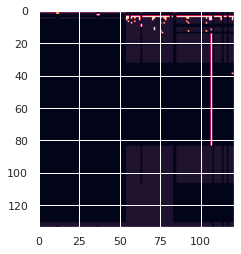

In [16]:
plt.imshow(np.array(list(details["values"].values)))
plt.show()

Excellent. As we can see from the image above, we now have a means of going from the testgrid dashboard of interest url directly to a 2d numpy representation of our grids where we could apply some 2D signal processing, computer vision or convolutional neural network methods (maybe).      

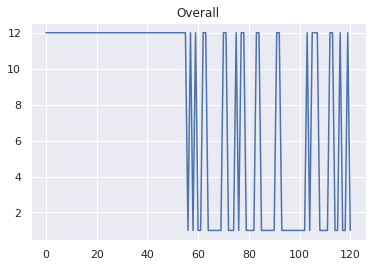

In [17]:
plt.plot(details["values"][0])
plt.title(details["name"][0])
plt.show()

We can also break it into a single time series, if we want to directly analyze the behavior of a single test with in this job. 

## Next steps

Now that we have a fairly clear view of the data available to us via testgrid and how to get it into a data science friendly format. The next thing we want to do is collect a large sample of this data and see how we can organize it in aggregate (across jobs). As this data appears to update at least daily, we also want to pull a large sample, so that we have a fixed data set to work with moving forward (one that is immutable (doesn't change on us every day), and available independent of the testgrid service).   